## Import

In [1]:
!pip install segmentation-models-pytorch -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.4 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
from sklearn.model_selection import train_test_split
import cv2 


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Try importing segmentation_models_pytorch
try:
    import segmentation_models_pytorch as smp
except ImportError:
    print("Please install segmentation_models_pytorch: pip install segmentation-models-pytorch")
    exit()

## CONFIG

In [4]:
NAME_VERSION = "unet-resnet34-v3.1"    
# Parameters
TRAIN_IMAGE_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images'
TRAIN_MASK_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/masks'
VAL_IMAGE_DIR = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/val/images'

OUTPUT_DIR = f'/kaggle/working/{NAME_VERSION}'

TARGET_SIZE = 512  # Higher resolution for better segmentation
BATCH_SIZE = 4     # Smaller batch size for higher resolution
NUM_EPOCHS = 40    # More epochs for better convergence
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5  # L2 regularization
USE_AMP = False     # Use mixed precision for faster training


SHRINK_MASKS = True  # Whether to apply mask shrinking
SHRINK_KERNEL_SIZE = 2  # Size of the kernel for erosion (larger = more shrinking)
SHRINK_ITERATIONS = 1  # Number of iterations for erosion

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
# Check if files exist in directories
if not os.path.exists(TRAIN_IMAGE_DIR):
    raise FileNotFoundError(f"Training image directory not found: {TRAIN_IMAGE_DIR}")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f"Training mask directory not found: {TRAIN_MASK_DIR}")
if not os.path.exists(VAL_IMAGE_DIR):
    raise FileNotFoundError(f"Validation image directory not found: {VAL_IMAGE_DIR}")

## Seed

In [7]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()


## Shrinking helper

In [8]:

# Add this function for mask shrinking
def shrink_mask(mask, kernel_size=3, iterations=1):
    """
    Shrink a binary mask using morphological erosion
    
    Args:
        mask: Binary mask to shrink (numpy array)
        kernel_size: Size of the erosion kernel (odd number)
        iterations: Number of times to apply erosion
        
    Returns:
        Shrunken binary mask
    """
    if kernel_size < 1 or iterations < 1:
        return mask
        
    # Ensure mask is binary
    binary_mask = (mask > 0).astype(np.uint8)
    
    # Create kernel for erosion
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply erosion
    eroded_mask = cv2.erode(binary_mask, kernel, iterations=iterations)
    
    return eroded_mask.astype(np.float32)

# For visualization purposes - to see the effect of shrinking
def visualize_mask_shrinking(original_image, original_mask, shrunk_mask, save_path):
    """
    Visualize the effect of mask shrinking as overlays on the original image
    
    Args:
        original_image: Original RGB image
        original_mask: Original binary mask
        shrunk_mask: Shrunk binary mask
        save_path: Path to save the visualization
    """
    plt.figure(figsize=(12, 6))
        
    # Create overlay for original mask (red color)
    overlay_original = original_image.copy()
    # Apply red mask with transparency
    overlay_original[original_mask > 0] = (
        overlay_original[original_mask > 0] * 0.7 + 
        np.array([255, 0, 0], dtype=np.uint8) * 0.3
    )
    
    # Create overlay for shrunk mask (green color)
    overlay_shrunk = original_image.copy()
    # Apply green mask with transparency
    overlay_shrunk[shrunk_mask > 0] = (
        overlay_shrunk[shrunk_mask > 0] * 0.7 + 
        np.array([0, 255, 0], dtype=np.uint8) * 0.3
    )
    plt.subplot(1, 2, 1)
    plt.imshow(overlay_original)
    plt.title("Original Mask Overlay")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay_shrunk)
    plt.title("Shrunk Mask Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

## Dataset and Transformation

In [9]:
# Dataset class for training
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir=None, transform=None, image_list=None, 
                 shrink_masks=False, shrink_kernel_size=3, shrink_iterations=1):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.shrink_masks = shrink_masks
        self.shrink_kernel_size = shrink_kernel_size
        self.shrink_iterations = shrink_iterations
        
        # Get list of image files
        if image_list is not None:
            self.images = image_list
        else:
            self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = np.array(Image.open(img_path).convert("RGB"))
        
        if self.mask_dir:  # Training or validation with masks
            mask_name = os.path.splitext(img_name)[0] + '.png'
            mask_path = os.path.join(self.mask_dir, mask_name)
            
            # Handle mask loading errors gracefully
            try:
                mask = np.array(Image.open(mask_path).convert("L"))  # Grayscale
                # Ensure mask is binary (0 or 1)
                mask = (mask > 0).astype(np.float32)
                                
                # Apply mask shrinking if enabled
                if self.shrink_masks:
                    # Store the original mask for potential debugging
                    original_mask = mask.copy()
                    mask = shrink_mask(
                        mask, 
                        kernel_size=self.shrink_kernel_size, 
                        iterations=self.shrink_iterations
                    )
            except Exception as e:
                print(f"Error loading mask {mask_path}: {e}")
                # Create an empty mask if there's an error
                mask = np.zeros(image.shape[:2], dtype=np.float32)
            
            if self.transform:
                augmentations = self.transform(image=image, mask=mask)
                image = augmentations["image"]
                mask = augmentations["mask"]
            return image, mask
        else:  # Test set, no masks
            if self.transform:
                augmentations = self.transform(image=image)
                image = augmentations["image"]
            return image, img_name

In [10]:
# Define transformations with specific target size for blast fragments
def get_transforms(train=True, target_size=512):  # Increased size for better detail
    if train:
        return A.Compose([
            A.Resize(height=target_size, width=target_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.GaussianBlur(p=0.3),
            A.GaussNoise(p=0.2),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=target_size, width=target_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

## Utils

In [11]:
# RLE encoding function from the competition description
def mask_to_rle(mask):
    """
    Convert a binary mask to run-length encoding (RLE)
    """
    # Flatten mask
    pixels = mask.flatten()
    # Compress the mask with RLE
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    # Convert to string
    rle = ' '.join(str(x) for x in runs)
    return rle

In [12]:
# RLE decoding function for the competition
def rle_to_mask(rle, shape):
    """
    Convert RLE to mask
    """
    if rle == '' or rle is None:
        return np.zeros(shape, dtype=np.uint8)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1  # RLE starts from 1, convert to 0-based indexing
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [13]:
# IoU (Jaccard Index) for evaluation as per competition metric
def iou_score(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [14]:
# Display predictions
def display_predictions(model, dataset, device, num_samples=3, save_path='predictions.png'):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Sample indices randomly
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            pred_mask = torch.sigmoid(output) > 0.5
        
        # Convert tensors to numpy for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()
        pred_mask_np = pred_mask.squeeze().cpu().numpy()
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        
        # Display
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title("Image")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask_np, cmap='gray')
        axes[i, 2].set_title("Prediction")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [15]:
# Save training history plot and metrics
def save_training_history(train_losses, val_losses, train_ious, val_ious, save_dir):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save metrics to CSV
    history = {
        'epoch': list(range(1, len(train_losses) + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_iou': train_ious,
        'val_iou': val_ious
    }
    pd.DataFrame(history).to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)
    
    # Plot training history
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['epoch'], train_losses, 'b-', label='Training Loss')
    plt.plot(history['epoch'], val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['epoch'], train_ious, 'b-', label='Training IoU')
    plt.plot(history['epoch'], val_ious, 'r-', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU Score')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close()

## Train and val helper

In [16]:
# Training function with mixed precision
def train_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    epoch_loss = 0
    iou_scores = []
    
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.float().to(device).unsqueeze(1)  # Add channel dimension
        
        # Use mixed precision if scaler is provided
        if scaler is not None:
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                
            # Scale gradients and optimize
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate IoU score for this batch
        with torch.no_grad():
            pred_masks = torch.sigmoid(outputs)
            iou = iou_score(pred_masks, masks)
            iou_scores.append(iou.item())
    
    return epoch_loss / len(loader), np.mean(iou_scores)

In [17]:
# Validation function
def valid_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0
    iou_scores = []
    
    with torch.no_grad():
        for images, masks in tqdm(loader):
            images = images.to(device)
            masks = masks.float().to(device).unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            pred_masks = torch.sigmoid(outputs)
            iou = iou_score(pred_masks, masks)
            iou_scores.append(iou.item())
    
    return epoch_loss / len(loader), np.mean(iou_scores)

## Prediction Helpers

In [18]:
# Prediction and RLE encoding for competition submission
def predict_and_encode(model, loader, device, target_size=512):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, img_names in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float().cpu().numpy()
            
            for pred_mask, img_name in zip(pred_masks, img_names):
                pred_mask = pred_mask.squeeze()  # Remove channel dimension
                # Convert to RLE format
                rle = mask_to_rle(pred_mask)
                image_id = os.path.splitext(img_name)[0]
                predictions.append({'id': image_id, 'rle': rle})
    
    return predictions

## Split train and val

In [19]:
# Get all images
all_images = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
print(f"Found {len(all_images)} images in training directory")

# Verify mask files exist for training images
valid_images = []
for img_file in all_images:
    mask_file = os.path.splitext(img_file)[0] + '.png'
    if os.path.exists(os.path.join(TRAIN_MASK_DIR, mask_file)):
        valid_images.append(img_file)

if len(valid_images) < len(all_images):
    print(f"Warning: Only {len(valid_images)} of {len(all_images)} images have corresponding masks")

# Split data into train and validation
train_images, valid_images = train_test_split(
    valid_images, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(valid_images)}")

Found 768 images in training directory
Training images: 614
Validation images: 154


## Visualize Shrink

In [20]:
# to visualize the effect of mask shrinking on a few samples
if SHRINK_MASKS:
    # Create directory for mask visualizations
    mask_viz_dir = os.path.join(OUTPUT_DIR, 'mask_visualizations')
    os.makedirs(mask_viz_dir, exist_ok=True)
    
    # Select a few random samples from validation set
    for i in range(5):
        # Load image and original mask
        img_name = valid_images[i]
        img_path = os.path.join(TRAIN_IMAGE_DIR, img_name)
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
        # Load original image
        original_image = np.array(Image.open(img_path).convert("RGB"))
        
        # Load and process the mask
        original_mask = np.array(Image.open(mask_path).convert("L"))
        original_mask = (original_mask > 0).astype(np.float32)
        
        # Apply shrinking
        shrunk_mask = shrink_mask(
            original_mask,
            kernel_size=SHRINK_KERNEL_SIZE,
            iterations=SHRINK_ITERATIONS
        )
        
        # Visualize
        visualize_mask_shrinking(
            original_image,
            original_mask, 
            shrunk_mask, 
            save_path=os.path.join(mask_viz_dir, f'mask_shrinking_sample_{i}.png')
        )
    
    print(f"Mask shrinking visualizations saved to '{mask_viz_dir}'")

Mask shrinking visualizations saved to '/kaggle/working/unet-resnet34-v3/mask_visualizations'


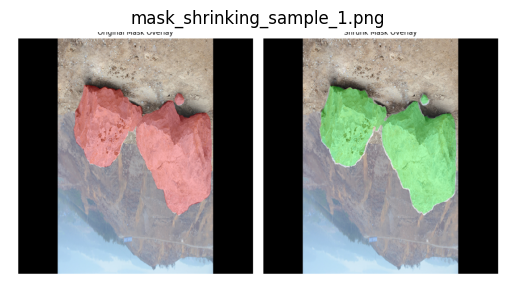

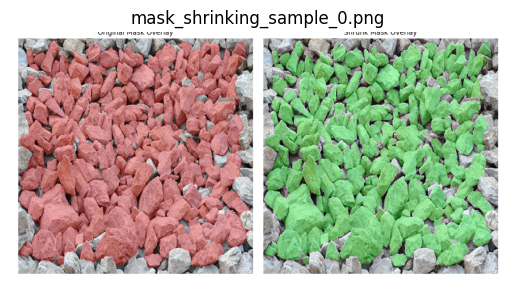

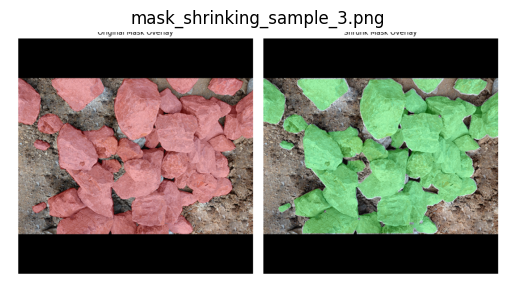

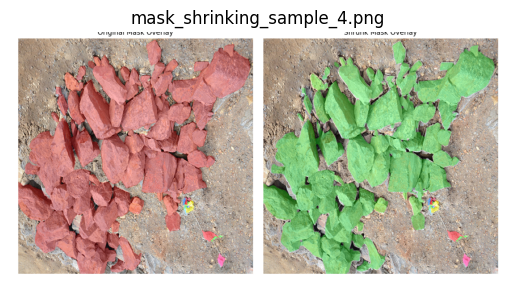

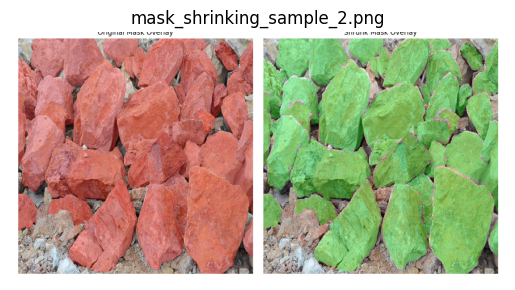

In [21]:
# Check if the folder exists
if SHRINK_MASKS:
    folder_path = mask_viz_dir
    # Get a list of files in the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # If there are no files in the folder
    if not image_files:
        print(f"No files found in '{folder_path}'.")
    else:
        # Display each image
        for image_file in image_files:
            try:
                # Construct the full image path
                image_path = os.path.join(folder_path, image_file)

                # Open the image using PIL (Pillow)
                img = Image.open(image_path)

                # Display the image using matplotlib
                plt.figure() # Create a new figure for each image
                plt.imshow(img)
                plt.title(image_file) # Optional: Add filename as title
                plt.axis('off')      # Optional: Turn off axis labels and ticks
                plt.show()

            except Exception as e:
                print(f"Error displaying image '{image_file}': {e}")

## DataLoader

In [22]:
# Define transformations
train_transform = get_transforms(train=True, target_size=TARGET_SIZE)
valid_transform = get_transforms(train=False, target_size=TARGET_SIZE)

# Data loaders with appropriate number of workers
num_workers = min(8, os.cpu_count() or 1)

train_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    image_list=train_images,
    shrink_masks=SHRINK_MASKS,
    shrink_kernel_size=SHRINK_KERNEL_SIZE,
    shrink_iterations=SHRINK_ITERATIONS
)

valid_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=valid_transform,
    image_list=valid_images,
    shrink_masks=SHRINK_MASKS,  # Apply to validation set too for consistency
    shrink_kernel_size=SHRINK_KERNEL_SIZE,
    shrink_iterations=SHRINK_ITERATIONS
)

test_dataset = SegmentationDataset(
    image_dir=VAL_IMAGE_DIR,
    mask_dir=None,
    transform=valid_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

## Model

In [23]:
# Model - try a different architecture
model = smp.UnetPlusPlus(  # UNet++ often performs better for medical-like segmentation
    encoder_name="efficientnet-b3",  # Higher capacity encoder
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 216MB/s]


## Loss/Optimizer/Scheduler/Scaler

In [24]:
# Loss function - Combined BCE and Dice loss for better boundary detection
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight  # Weight for BCE vs Dice
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        # BCE Loss
        bce_loss = self.bce(pred, target)
        
        # Dice Loss
        pred_sigmoid = torch.sigmoid(pred)
        intersection = (pred_sigmoid * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)
        
        # Combine losses
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

criterion = BCEDiceLoss(weight=0.7)

# Initialize mixed precision scaler
scaler = GradScaler() if USE_AMP and DEVICE.type == 'cuda' else None


# Optimizer with weight decay for regularization
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler with cosine annealing
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Restart every 5 epochs
    T_mult=1, 
    eta_min=1e-6
)

## Traing loop

In [25]:
# Training loop
best_iou = -1
model_save_path = os.path.join(OUTPUT_DIR, "best_model.pth")

# For tracking metrics
train_losses, val_losses = [], []
train_ious, val_ious = [], []

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, train_iou = train_epoch(model, train_loader, optimizer, criterion, DEVICE, scaler)
    
    # Validate
    valid_loss, valid_iou = valid_epoch(model, valid_loader, criterion, DEVICE)
    
    # Update learning rate
    scheduler.step()
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_ious.append(train_iou)
    val_ious.append(valid_iou)
    
    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if valid_iou > best_iou:
        best_iou = valid_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_iou': best_iou,
        }, model_save_path)
        print(f"Saved best model to {model_save_path}!")

# Calculate training time
time_elapsed = time.time() - start_time
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best validation IoU: {best_iou:.4f}')

Epoch 1/40


100%|██████████| 39/39 [00:03<00:00, 10.59it/s]


Train Loss: 0.2865, Train IoU: 0.7596
Valid Loss: 0.1765, Valid IoU: 0.8502
Learning rate: 0.000452
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 2/40


100%|██████████| 39/39 [00:03<00:00, 10.92it/s]


Train Loss: 0.1948, Train IoU: 0.8378
Valid Loss: 0.1660, Valid IoU: 0.8545
Learning rate: 0.000328
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 3/40


100%|██████████| 39/39 [00:03<00:00, 10.86it/s]


Train Loss: 0.1704, Train IoU: 0.8532
Valid Loss: 0.1422, Valid IoU: 0.8728
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 4/40


100%|██████████| 39/39 [00:03<00:00, 10.91it/s]


Train Loss: 0.1542, Train IoU: 0.8679
Valid Loss: 0.1310, Valid IoU: 0.8810
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 5/40


100%|██████████| 39/39 [00:03<00:00, 10.72it/s]


Train Loss: 0.1428, Train IoU: 0.8751
Valid Loss: 0.1226, Valid IoU: 0.8878
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 6/40


100%|██████████| 39/39 [00:03<00:00, 10.92it/s]


Train Loss: 0.1555, Train IoU: 0.8646
Valid Loss: 0.1502, Valid IoU: 0.8729
Learning rate: 0.000452
Epoch 7/40


100%|██████████| 39/39 [00:03<00:00, 10.72it/s]


Train Loss: 0.1439, Train IoU: 0.8731
Valid Loss: 0.1232, Valid IoU: 0.8866
Learning rate: 0.000328
Epoch 8/40


100%|██████████| 39/39 [00:03<00:00, 10.63it/s]


Train Loss: 0.1348, Train IoU: 0.8817
Valid Loss: 0.1164, Valid IoU: 0.8931
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 9/40


100%|██████████| 39/39 [00:03<00:00, 10.89it/s]


Train Loss: 0.1332, Train IoU: 0.8869
Valid Loss: 0.1052, Valid IoU: 0.9027
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 10/40


100%|██████████| 39/39 [00:03<00:00, 10.89it/s]


Train Loss: 0.1198, Train IoU: 0.8927
Valid Loss: 0.1013, Valid IoU: 0.9051
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 11/40


100%|██████████| 39/39 [00:03<00:00, 10.98it/s]


Train Loss: 0.1244, Train IoU: 0.8885
Valid Loss: 0.1091, Valid IoU: 0.8984
Learning rate: 0.000452
Epoch 12/40


100%|██████████| 39/39 [00:03<00:00, 10.91it/s]


Train Loss: 0.1220, Train IoU: 0.8901
Valid Loss: 0.1040, Valid IoU: 0.9024
Learning rate: 0.000328
Epoch 13/40


100%|██████████| 39/39 [00:03<00:00, 10.97it/s]


Train Loss: 0.1157, Train IoU: 0.8968
Valid Loss: 0.1042, Valid IoU: 0.9021
Learning rate: 0.000173
Epoch 14/40


100%|██████████| 39/39 [00:03<00:00, 11.00it/s]


Train Loss: 0.1081, Train IoU: 0.9024
Valid Loss: 0.0937, Valid IoU: 0.9118
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 15/40


100%|██████████| 39/39 [00:03<00:00, 10.40it/s]


Train Loss: 0.1034, Train IoU: 0.9068
Valid Loss: 0.0893, Valid IoU: 0.9156
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 16/40


100%|██████████| 39/39 [00:03<00:00, 10.90it/s]


Train Loss: 0.1096, Train IoU: 0.9014
Valid Loss: 0.0935, Valid IoU: 0.9129
Learning rate: 0.000452
Epoch 17/40


100%|██████████| 39/39 [00:03<00:00, 10.91it/s]


Train Loss: 0.1077, Train IoU: 0.9030
Valid Loss: 0.0905, Valid IoU: 0.9144
Learning rate: 0.000328
Epoch 18/40


100%|██████████| 39/39 [00:03<00:00, 10.97it/s]


Train Loss: 0.1013, Train IoU: 0.9090
Valid Loss: 0.0829, Valid IoU: 0.9211
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 19/40


100%|██████████| 39/39 [00:03<00:00, 10.88it/s]


Train Loss: 0.0959, Train IoU: 0.9129
Valid Loss: 0.0805, Valid IoU: 0.9238
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 20/40


100%|██████████| 39/39 [00:03<00:00, 10.88it/s]


Train Loss: 0.0914, Train IoU: 0.9170
Valid Loss: 0.0792, Valid IoU: 0.9247
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 21/40


100%|██████████| 39/39 [00:03<00:00, 10.92it/s]


Train Loss: 0.1114, Train IoU: 0.9009
Valid Loss: 0.0942, Valid IoU: 0.9127
Learning rate: 0.000452
Epoch 22/40


100%|██████████| 39/39 [00:03<00:00, 10.51it/s]


Train Loss: 0.1049, Train IoU: 0.9055
Valid Loss: 0.0864, Valid IoU: 0.9185
Learning rate: 0.000328
Epoch 23/40


100%|██████████| 39/39 [00:03<00:00, 10.86it/s]


Train Loss: 0.0974, Train IoU: 0.9123
Valid Loss: 0.0809, Valid IoU: 0.9241
Learning rate: 0.000173
Epoch 24/40


100%|██████████| 39/39 [00:03<00:00, 10.93it/s]


Train Loss: 0.0906, Train IoU: 0.9180
Valid Loss: 0.0756, Valid IoU: 0.9275
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 25/40


100%|██████████| 39/39 [00:03<00:00, 10.96it/s]


Train Loss: 0.0870, Train IoU: 0.9210
Valid Loss: 0.0739, Valid IoU: 0.9291
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 26/40


100%|██████████| 39/39 [00:03<00:00, 10.93it/s]


Train Loss: 0.0934, Train IoU: 0.9154
Valid Loss: 0.0791, Valid IoU: 0.9254
Learning rate: 0.000452
Epoch 27/40


100%|██████████| 39/39 [00:03<00:00, 10.94it/s]


Train Loss: 0.0937, Train IoU: 0.9153
Valid Loss: 0.0803, Valid IoU: 0.9247
Learning rate: 0.000328
Epoch 28/40


100%|██████████| 39/39 [00:03<00:00, 10.97it/s]


Train Loss: 0.0873, Train IoU: 0.9206
Valid Loss: 0.0731, Valid IoU: 0.9306
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 29/40


100%|██████████| 39/39 [00:03<00:00, 10.69it/s]


Train Loss: 0.0860, Train IoU: 0.9226
Valid Loss: 0.0777, Valid IoU: 0.9285
Learning rate: 0.000049
Epoch 30/40


100%|██████████| 39/39 [00:03<00:00, 10.94it/s]


Train Loss: 0.0815, Train IoU: 0.9262
Valid Loss: 0.0697, Valid IoU: 0.9341
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 31/40


100%|██████████| 39/39 [00:03<00:00, 11.05it/s]


Train Loss: 0.0959, Train IoU: 0.9142
Valid Loss: 0.0787, Valid IoU: 0.9256
Learning rate: 0.000452
Epoch 32/40


100%|██████████| 39/39 [00:03<00:00, 10.99it/s]


Train Loss: 0.0875, Train IoU: 0.9208
Valid Loss: 0.0720, Valid IoU: 0.9316
Learning rate: 0.000328
Epoch 33/40


100%|██████████| 39/39 [00:03<00:00, 10.92it/s]


Train Loss: 0.0834, Train IoU: 0.9246
Valid Loss: 0.0683, Valid IoU: 0.9349
Learning rate: 0.000173
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 34/40


100%|██████████| 39/39 [00:03<00:00, 10.94it/s]


Train Loss: 0.0797, Train IoU: 0.9279
Valid Loss: 0.0668, Valid IoU: 0.9356
Learning rate: 0.000049
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 35/40


100%|██████████| 39/39 [00:03<00:00, 11.02it/s]


Train Loss: 0.0776, Train IoU: 0.9296
Valid Loss: 0.0647, Valid IoU: 0.9375
Learning rate: 0.000500
Saved best model to /kaggle/working/unet-resnet34-v3/best_model.pth!
Epoch 36/40


100%|██████████| 39/39 [00:03<00:00, 10.41it/s]


Train Loss: 0.0837, Train IoU: 0.9242
Valid Loss: 0.0715, Valid IoU: 0.9327
Learning rate: 0.000452
Epoch 37/40


100%|██████████| 39/39 [00:03<00:00, 11.11it/s]


Train Loss: 0.0855, Train IoU: 0.9226
Valid Loss: 0.0905, Valid IoU: 0.9243
Learning rate: 0.000328
Epoch 38/40


100%|██████████| 39/39 [00:03<00:00, 10.88it/s]


Train Loss: 0.1137, Train IoU: 0.9030
Valid Loss: 0.0712, Valid IoU: 0.9325
Learning rate: 0.000173
Epoch 39/40


100%|██████████| 39/39 [00:03<00:00, 10.99it/s]


Train Loss: 0.0824, Train IoU: 0.9258
Valid Loss: 0.0690, Valid IoU: 0.9342
Learning rate: 0.000049
Epoch 40/40


100%|██████████| 39/39 [00:03<00:00, 11.00it/s]

Train Loss: 0.0783, Train IoU: 0.9290
Valid Loss: 0.0660, Valid IoU: 0.9367
Learning rate: 0.000500
Training complete in 36m 45s
Best validation IoU: 0.9375


## Save

In [26]:
# Save training history
save_training_history(train_losses, val_losses, train_ious, val_ious, OUTPUT_DIR)

# Load best model for evaluation and prediction
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])

# Validate with best model
valid_loss, valid_iou = valid_epoch(model, valid_loader, criterion, DEVICE)
print(f"Best model - Valid Loss: {valid_loss:.4f}, Valid IoU: {valid_iou:.4f}")

# Save visualizations of predictions
display_predictions(
    model, 
    valid_dataset, 
    DEVICE, 
    num_samples=5, 
    save_path=os.path.join(OUTPUT_DIR, 'predictions.png')
)
print(f"Predictions visualization saved to '{os.path.join(OUTPUT_DIR, 'predictions.png')}'")

<ipython-input-26-11cae5e55e3a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path)
100%|██████████| 39/39 [00:03<00:00, 10.85it/s]


Best model - Valid Loss: 0.0647, Valid IoU: 0.9375
Predictions visualization saved to '/kaggle/working/unet-resnet34-v3/predictions.png'


## Infer

In [27]:
# Generate predictions for test set and save in RLE format
test_predictions = predict_and_encode(model, test_loader, DEVICE, target_size=TARGET_SIZE)
submission_df = pd.DataFrame(test_predictions)
submission_path = os.path.join(OUTPUT_DIR, 'submission.csv')
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to '{submission_path}'")

100%|██████████| 48/48 [00:04<00:00, 10.73it/s]


Submission file saved to '/kaggle/working/unet-resnet34-v3/submission.csv'
